In [17]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
from Preprocessing.labeling import resample_close, get_t1, get_events, get_lookback_vol
from Research.fx_utils import fx_data_import, bbg_data_import
from Research.FXTesting import pca_distance_loop, get_nonusd_pair_data, get_nonusd_pairs, get_nonusd_close
from Preprocessing.sampling import _get_num_concurrent_events
from Preprocessing.etf_trick import ETFTrick
from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_pnl

home_machine = True
gen_tricks = False
start_date = dt.datetime(2000,1,1)
# implement citi reversion



if home_machine:
    close = fx_data_import()
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes = get_nonusd_close(close, nonusd_pairs)
    tr_df = pair_closes.dropna(how='any')
else:
    close, yields = bbg_data_import(vs_dollar=True)
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes, cross_yields = get_nonusd_pair_data(close, yields, nonusd_pairs)
    cross_yields = cross_yields.fillna(0)/100./365.

if not gen_tricks:
    close = close.loc[start_date:]
    pair_closes = pair_closes.loc[start_date:]

#   if we wanted to drop the union of NAs
#    cross_yields = crosses.merge(yields, left_index=True, right_index=True, suffixes=('_px','_yld'))

# generate the indicator matrix whether pair is within cluster_threshold based on pca distances
group_matrix = pca_distance_loop(close, 100, 4, 0.2, nonusd_pairs, components_to_use=[1,2,3])

# generate x-sigma signals
zscores = lookback_zscore(pair_closes, 30, 200)
signals = zscore_signal(zscores, 2, 'Reversion')

# only take signals where the pair is 'grouped' at the time
group_signals = signals.multiply(group_matrix.loc[signals.index[0]:])
events_arr = []
tricks = []
if not gen_tricks:
    norm_srs = pd.read_excel(r"C:\Users\Brendan\FinML\MLFin\raw_data\nocarrytrickdata.xlsx", index_col=0)
    norm_srs = norm_srs.loc[start_date:]

for pair in nonusd_pairs:
    # skip if theres no group
    if (len(group_signals[pair][abs(group_signals[pair])>0]) == 0) or pair not in norm_srs.columns:
        continue
    
    print(pair, dt.datetime.now())
    
    weights = pd.DataFrame(np.ones(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
    
    # ETF trick on one pair
    # check if we're using yields
    if gen_tricks:
        if home_machine:
            carry = pd.DataFrame(np.zeros(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, carry)

        else:
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, cross_yields)
        tr_s = tr.get_etf_series()
        tricks.append(tr_s)
    else:
        tr_s = norm_srs[pair]
        
    events0 = zscore_sizing(group_signals[pair], pair_closes[pair], 100, 50, 200)
    if events0 is None:
        continue
    events = generate_pnl(events0, tr_s)
    events_arr.append(events)



BRLCAD 2020-02-11 19:59:02.895603
BRLCNY 2020-02-11 19:59:03.147453
BRLINR 2020-02-11 19:59:03.211934
BRLMXN 2020-02-11 19:59:03.274896
BRLZAR 2020-02-11 19:59:03.663647


C:\Users\Brendan\FinML\MLFin\Preprocessing\labeling.py:102: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt = trgt.loc[events.index]
C:\Users\Brendan\FinML\MLFin\Preprocessing\labeling.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  events['t1'] = df0.dropna(how='all').min(axis=1)


BRLSLR 2020-02-11 19:59:04.105071
BRLSGD 2020-02-11 19:59:04.140639
BRLTWD 2020-02-11 19:59:04.172632
BRLAUD 2020-02-11 19:59:04.215611
BRLNZD 2020-02-11 19:59:04.264569
BRLGBP 2020-02-11 19:59:04.367509
CADCNY 2020-02-11 19:59:04.537560
CADDKK 2020-02-11 19:59:04.605526
CADHKD 2020-02-11 19:59:04.639508
CADINR 2020-02-11 19:59:04.781851
CADKRW 2020-02-11 19:59:04.939757
CADMXN 2020-02-11 19:59:05.054704
CADNOK 2020-02-11 19:59:05.298975
CADSEK 2020-02-11 19:59:05.373794
CADZAR 2020-02-11 19:59:05.470738
CADCHF 2020-02-11 19:59:05.812976
CADSGD 2020-02-11 19:59:05.835962
CADTWD 2020-02-11 19:59:06.002464
CADTHB 2020-02-11 19:59:06.206972
CADAUD 2020-02-11 19:59:06.264670
CADEUR 2020-02-11 19:59:06.690652
CADNZD 2020-02-11 19:59:06.713636
CADGBP 2020-02-11 19:59:07.071529
CNYHKD 2020-02-11 19:59:07.357593
CNYINR 2020-02-11 19:59:07.445556
CNYSLR 2020-02-11 19:59:07.613102
CNYSGD 2020-02-11 19:59:07.773721
CNYTWD 2020-02-11 19:59:07.891299
CNYTHB 2020-02-11 19:59:08.052661
CNYAUD 2020-02

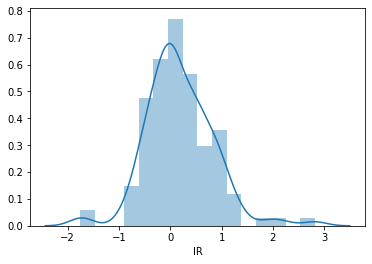

In [49]:
import seaborn as sns
cumul_pnl = pd.Series([e['ret'].sum() for e in events_arr])
std_pnl = pd.Series([e['ret'].std() for e in events_arr])
avg_pnl = pd.Series([e['ret'].mean() for e in events_arr])
pnl_df = pd.concat([cumul_pnl, std_pnl, avg_pnl], axis=1, keys=['cumul','std','mean'])
#sns.distplot(avg_pnl/std_pnl)
pnl_df['IR'] = pnl_df['mean']/pnl_df['std']
sns.distplot(pnl_df['IR'].dropna())